### Посчитать tpr и fpr в ноутбуке к лекции. Убедиться, что график ROC AUC получается таким же, как и штатными средствами.

In [1]:
import pandas as pd
import numpy as np

In [14]:
data = pd.read_csv('affair_data.csv')
data.head()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affair
0,3.0,32.0,9.0,3.0,3.0,17.0,2.0,5.0,1
1,3.0,27.0,13.0,3.0,1.0,14.0,3.0,4.0,1
2,4.0,22.0,2.5,0.0,1.0,16.0,3.0,5.0,1
3,4.0,37.0,16.5,4.0,3.0,16.0,5.0,5.0,1
4,5.0,27.0,9.0,1.0,1.0,14.0,3.0,4.0,1


In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6366 entries, 0 to 6365
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   rate_marriage    6366 non-null   float64
 1   age              6366 non-null   float64
 2   yrs_married      6366 non-null   float64
 3   children         6366 non-null   float64
 4   religious        6366 non-null   float64
 5   educ             6366 non-null   float64
 6   occupation       6366 non-null   float64
 7   occupation_husb  6366 non-null   float64
 8   affair           6366 non-null   int64  
dtypes: float64(8), int64(1)
memory usage: 447.7 KB


In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

In [20]:
X = data[data.columns[:-1]]    ### Формируем набор признаков и целевую переменную
X.head(5)

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb
0,3.0,32.0,9.0,3.0,3.0,17.0,2.0,5.0
1,3.0,27.0,13.0,3.0,1.0,14.0,3.0,4.0
2,4.0,22.0,2.5,0.0,1.0,16.0,3.0,5.0
3,4.0,37.0,16.5,4.0,3.0,16.0,5.0,5.0
4,5.0,27.0,9.0,1.0,1.0,14.0,3.0,4.0


In [21]:
Y = data['affair']
Y.head(5)

0    1
1    1
2    1
3    1
4    1
Name: affair, dtype: int64

In [22]:
model = LogisticRegression( penalty = 'l2', C = 0.01, solver='liblinear')

In [23]:
### Разбиваем данные на обучающую и тестовую выборки в соотношении 70 / 30

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 0 )

In [24]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_test = sc.fit_transform(X_test)
X_train = sc.transform(X_train)

In [25]:
model.fit(X_train, Y_train) ### Обучаем модель

LogisticRegression(C=0.01, solver='liblinear')

In [26]:
predictions = model.predict_proba(X_test)   ### Получаем прогнозные значения модели (переменная predictions)

In [27]:
model.score(X_test, Y_test)

0.7261780104712042

#### Считаем accuracy, TPR, FPR, Precision, Recall

In [30]:
tp = 0 # True positive
fp = 0 # False positive
fn = 0 # False negative
tn = 0 # True negative
prec = []
tpr2 = []
fpr2 = []
thresholds = np.arange(0, 1, 0.1)
# for threshold in thresholds:
def thres(predictions, Y_test, threshold=0.5, tp=0, fp=0, fn=0, tn=0):    
    for predicted_prob, actual in zip(predictions[:, 1], Y_test):
        if predicted_prob >= threshold:
            predicted = 1
        else:
            predicted = 0
    
        if predicted == 1:
            if actual == 1:
                tp += 1
            else:
                fp += 1  

        else:
            if actual == 1:
                fn += 1
            else:
                tn += 1    
    return tp / (tp + fp), (fp / (fp + tn)), (tp / (tp + fn)), ((tp + tn) / (tp + fp + fn + tn))


for threshold in thresholds:
    z = thres(predictions, Y_test, threshold)
    prec.append(z[0])
    fpr2.append(z[1])
    tpr2.append(z[2])
    
print(f'accuracy = {thres(predictions, Y_test, threshold=0.5)[3]}')  ### Верность модели
print (f'recall = {thres(predictions, Y_test, threshold=0.5)[2]}')
print (f'precision = {thres(predictions, Y_test, threshold=0.5)[0]}')
print (f'TPR = {thres(predictions, Y_test, threshold=0.5)[2]}')
print (f'FPR = {thres(predictions, Y_test, threshold=0.5)[1]}') 

accuracy = 0.7261780104712042
recall = 0.35914332784184516
precision = 0.6193181818181818
TPR = 0.35914332784184516
FPR = 0.10283960092095165


In [31]:
from sklearn.metrics import roc_curve

In [32]:
### Получаем значения false и true positive rate для различных значений порога

fpr, tpr, thres = roc_curve( Y_test, predictions[:, 1] )

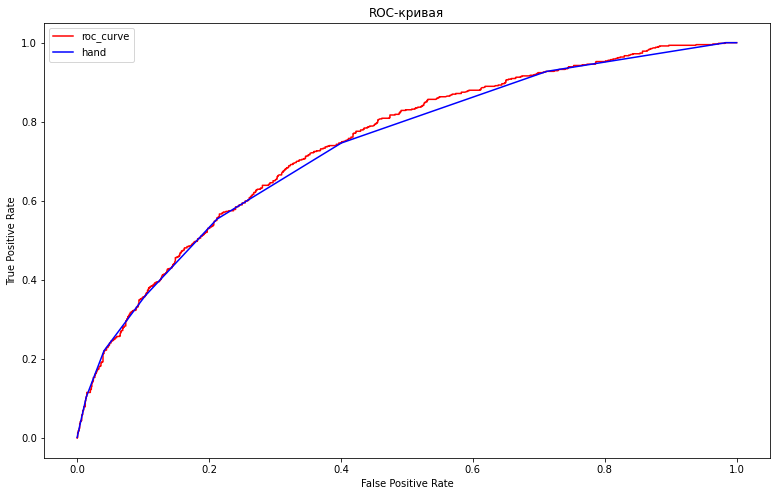

In [33]:
### Строим график ROC-кривой для "ручного" и машинного подсчёта fpr & tpr

fig, axes = plt.subplots(figsize = (13, 8))
axes.set_title(label='ROC-кривая')
axes.plot(fpr, tpr, 'r', label='roc_curve')
axes.plot( fpr2, tpr2, 'b', label='hand')
axes.set_xlabel('False Positive Rate')
axes.set_ylabel('True Positive Rate')
axes.legend()

In [34]:
from sklearn.metrics import auc    ### Площадь под кривой
auc(fpr, tpr), auc(fpr2, tpr2)

(0.7430489265046699, 0.7342686564144839)

### Построить график Precision - Recall на этих же данных.

In [35]:
from sklearn.metrics import precision_recall_curve
pr, re, thres = precision_recall_curve( Y_test, predictions[:, 1] )

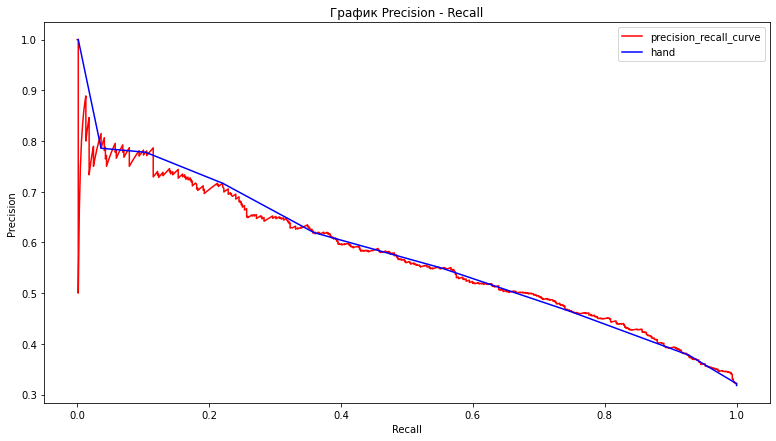

In [40]:
fig, axes = plt.subplots(figsize = (13, 7))
axes.set_title(label='График Precision - Recall')
axes.plot(re, pr, 'r', label='precision_recall_curve')
axes.plot( tpr2, prec, 'b', label='hand')
axes.set_xlabel('Recall')
axes.set_ylabel('Precision')
axes.legend()

In [42]:
from sklearn.metrics import average_precision_score

In [43]:
average_precision_score( Y_test, predictions[:, 1] )    ### Площадь под кривой

0.5720367255000708